# EDSA Apple Prices Challenge

Regression_AM2_DSFT team is determined to help the Fresh Produce Industry to accurately determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

In the Fresh Produce Industry, having the right amount of stock on hand is crucial. That's, not having too little that you run out of stock when customers want to buy more. And not having too much that food waste occurs. Yields from farms fluctuate by season. Should the prices then also fluctuate by season? The is a need for a more accurate method to determine how much stock to have on hand and what price to set the Golden Delicious Apples to.

Regression_AM2_DSFT will investigate key factors that have a great impact on the price of the Golden Delicious Apples to be maximised. We will construct a regression algorithm, capable of accurately predicting how much a kilogram of Golden Delicious Apples will cost, given certain parameters.

![Golden Apples](apples.png)


## Data Cleaning and Formatting
Before we do anything, we first have to clean our data. Our data contains negative values that don't make sense, i.e. a negative weight doesn't exist. We'll go now convert all the negative values into positive values.

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

### Datasets

In [2]:
df_train = pd.read_csv("df-train_set.csv")
df_test = pd.read_csv("df-test_set.csv")
test_index = df_test['Index']
df_test = df_test.drop('Index', axis = 1)

In [3]:
df_train = df_train[df_train['Commodities'] == 'APPLE GOLDEN DELICIOUS']

**Let's first take a look at our training data**

In [4]:
df_train.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2020-09-09,150.0,170.0,51710.0,332,6075.6,822,8.51
7,CAPE,JG110,2M,11.0,APPLE GOLDEN DELICIOUS,2020-04-14,50.0,50.0,16000.0,320,3520.0,0,4.55
24,W.CAPE-BERGRIVER ETC,JE090,2S,9.0,APPLE GOLDEN DELICIOUS,2020-04-16,55.0,55.0,990.0,18,162.0,1506,6.11
40,CAPE,M4183,1S,18.3,APPLE GOLDEN DELICIOUS,2020-05-04,80.0,120.0,32020.0,388,7100.4,443,4.51
69,EASTERN CAPE,IA400,1S,400.0,APPLE GOLDEN DELICIOUS,2020-09-28,1800.0,1800.0,1800.0,1,400.0,2,4.50


In [5]:
df_train.shape

(1952, 13)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 1 to 64310
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Province          1952 non-null   object 
 1   Container         1952 non-null   object 
 2   Size_Grade        1952 non-null   object 
 3   Weight_Kg         1952 non-null   float64
 4   Commodities       1952 non-null   object 
 5   Date              1952 non-null   object 
 6   Low_Price         1952 non-null   float64
 7   High_Price        1952 non-null   float64
 8   Sales_Total       1952 non-null   float64
 9   Total_Qty_Sold    1952 non-null   int64  
 10  Total_Kg_Sold     1952 non-null   float64
 11  Stock_On_Hand     1952 non-null   int64  
 12  avg_price_per_kg  1952 non-null   float64
dtypes: float64(6), int64(2), object(5)
memory usage: 213.5+ KB


In [7]:
# missing values
def total_missing(df):
    mis_val = df.isnull().sum()
    return mis_val

In [8]:
total_missing(df_train)

Province            0
Container           0
Size_Grade          0
Weight_Kg           0
Commodities         0
Date                0
Low_Price           0
High_Price          0
Sales_Total         0
Total_Qty_Sold      0
Total_Kg_Sold       0
Stock_On_Hand       0
avg_price_per_kg    0
dtype: int64

In [9]:
df_train.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
count,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000,1952.000000
mean,40.460912,174.307377,215.648053,20053.533811,174.510758,2960.176332,408.393955,6.778893
std,99.655169,373.553578,433.546159,39005.069445,308.810797,6097.416527,724.450582,2.248744
min,3.000000,2.000000,5.000000,5.000000,1.000000,3.000000,0.000000,0.250000
25%,9.000000,50.000000,60.000000,1325.000000,12.000000,219.600000,9.000000,5.460000
50%,12.000000,80.000000,108.000000,5495.000000,64.000000,853.500000,126.500000,6.670000
75%,18.300000,127.250000,160.000000,21082.500000,200.000000,3093.525000,468.000000,8.280000
max,400.000000,2300.000000,3300.000000,369464.000000,4237.000000,74000.000000,6400.000000,21.240000


By just looking at the above summary statistics, one can see that the values are not evenly distributed, we have very small values such as the minimum value of the variable `Low_Price` and big values such as the maximum of the variable `Stock_On_Hand`. This problem can have a negative impact on how well our model perform. Therefore, we will standardise our variables.

There's something wrong with our variable `avg_price_per_kg`, it has `infinity` values. The presence of `infinity` values in this variable is preventing us to compute summary statistics, as a result we don't know much about this variable. Let's go ahead and find out what is really going on

We have `eight` rows with `infinity` values. To get the values of `avg_price_per_kg`, we divide `Sales_Total` by `Total_Kg_Sold`. In mathematics, it is not allowed to divide any number by `zero`. All these rows have `Total_Kg_Sold` of `zero`. Therefore, it makes sense why their corresponding `avg_price_per_kg` variable contains infinity values.

So what are we going to do with this information, **we'll delete all the rows with infinity values**. Our data has `64376`, hopefully deleting this `8` rows won't have a great impact on the performance of our model.

#### Test Data

In [10]:
df_test.head(2)

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
0,W.CAPE-BERGRIVER ETC,EC120,1M,12.0,APPLE GOLDEN DELICIOUS,09/07/2020,128.0,136.0,5008.0,38,456.0,0
1,W.CAPE-BERGRIVER ETC,M4183,1X,18.3,APPLE GOLDEN DELICIOUS,20/01/2020,220.0,220.0,1760.0,8,146.4,2


In [11]:
df_test.columns

Index(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities',
       'Date', 'Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold',
       'Total_Kg_Sold', 'Stock_On_Hand'],
      dtype='object')

In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685 entries, 0 to 684
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province        685 non-null    object 
 1   Container       685 non-null    object 
 2   Size_Grade      685 non-null    object 
 3   Weight_Kg       685 non-null    float64
 4   Commodities     685 non-null    object 
 5   Date            685 non-null    object 
 6   Low_Price       685 non-null    float64
 7   High_Price      685 non-null    float64
 8   Sales_Total     685 non-null    float64
 9   Total_Qty_Sold  685 non-null    int64  
 10  Total_Kg_Sold   685 non-null    float64
 11  Stock_On_Hand   685 non-null    int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 64.3+ KB


In [13]:
df_test.describe()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand
count,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000,685.000000
mean,34.142482,164.202891,195.590073,18788.111212,174.883212,2725.402336,439.245255
std,87.575995,355.167319,389.109476,33951.586813,299.351142,5059.123311,715.985761
min,3.000000,10.000000,10.000000,10.000000,1.000000,6.300000,0.000000
25%,9.000000,50.000000,64.000000,1300.000000,13.000000,204.000000,20.000000
50%,12.000000,80.000000,112.000000,5520.000000,62.000000,860.100000,153.000000
75%,18.300000,128.000000,160.000000,21176.000000,200.000000,3033.000000,516.000000
max,400.000000,2400.000000,2400.000000,308010.000000,2774.000000,47200.000000,6827.000000


Now we'll go ahead and remove all the rows with infinity values

In [14]:
# Seasons Generating Function
def season(x, date_format):
    date_str = [str(i) for i in x]
    months = [datetime.strptime(i, date_format).month for i in date_str]
    
    dict_ = {1: 'January',
             2: 'February',
             3: 'March',
             4: 'April',
             5: 'May',
             6: 'June',
             7: 'July',
             8: 'August',
             9: 'September',
             10: 'October',
             11: 'November',
             12: 'December'}
    
    seasons = [dict_[month] for month in months] 
    
    return seasons

In [15]:
#df_test['Season'] = pd.DataFrame(season(df_test.Date, '%d/%m/%Y'))
#df_test.head(2)

Since we don't need the date column anymore, we can drop it

In [16]:
df_test = df_test.drop(columns = ['Date'])

In [17]:
#df_train['Season'] = pd.DataFrame(season(df_train.Date, '%Y-%m-%d'))
#df_train.head(2)

Let's drop the date column

In [18]:
df_train = df_train.drop(columns = ['Date'])

In [19]:
a = df_train.Commodities.unique()
a

array(['APPLE GOLDEN DELICIOUS'], dtype=object)

In [20]:
df_test.Commodities.unique()

array(['APPLE GOLDEN DELICIOUS'], dtype=object)

We'll change the values of `Commodities` variable to `APPLE GOLDEN DELICIOUS`

Since all the data now contain `one` commodity, we might as well delete the variable `Commodities`

In [21]:
df_train = df_train.drop(columns = ['Commodities'])

In [22]:
b = df_train.Container.unique()
b

array(['M4183', 'JG110', 'JE090', 'IA400', 'EC120', 'AC030', 'M6125',
       'EF120', 'DT063', 'M9125', 'EG140'], dtype=object)

In [23]:
x = df_test.Container.unique()
x

array(['EC120', 'M4183', 'IA400', 'JG110', 'JE090', 'M6125', 'EF120',
       'AC030', 'DT063', 'M9125', 'EG140'], dtype=object)

In [24]:
x = set(x)
y = set(b)
x.issubset(y)

True

In [25]:
c = df_train.Province.unique()
c

array(['CAPE', 'W.CAPE-BERGRIVER ETC', 'EASTERN CAPE', 'NATAL',
       'WEST COAST', 'TRANSVAAL', 'ORANGE FREE STATE'], dtype=object)

In [26]:
df_test.Province.unique()

array(['W.CAPE-BERGRIVER ETC', 'CAPE', 'NATAL', 'EASTERN CAPE',
       'ORANGE FREE STATE', 'WEST COAST', 'TRANSVAAL'], dtype=object)

In [27]:
d = df_train.Size_Grade.unique()
d

array(['1L', '2M', '2S', '1S', '1M', '1X', '2L', '2U', '2X', '1U'],
      dtype=object)

In [28]:
df_test.Size_Grade.unique()

array(['1M', '1X', '1S', '1L', '2S', '2M', '2U', '2L', '2X', '1U'],
      dtype=object)

## Exploratory Data Analysis

### Univariate Analysis

This project is all about building a model that predict the price of the `Golden Delicious Apples`, so it before we start building our model, we should try to learn more about this price. The price of the `Golden Delicious Apples` in our dataset is represented by the variable `avg_price_per_kg`. We'll go ahead and look at the summary statistics of this variable.

In [29]:
df_train.avg_price_per_kg.describe()

count    1952.000000
mean        6.778893
std         2.248744
min         0.250000
25%         5.460000
50%         6.670000
75%         8.280000
max        21.240000
Name: avg_price_per_kg, dtype: float64

Very well... It seems that our minimum price is larger than zero. Now let's look at its distribution

C:\DSToolkit\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='avg_price_per_kg', ylabel='Density'>

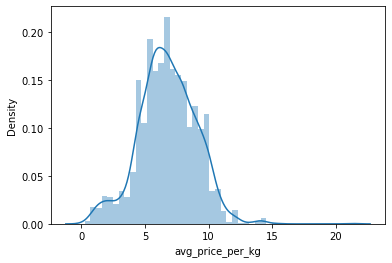

In [30]:
#histogram
sns.distplot(df_train['avg_price_per_kg'])

Excellent!, we can see that `avg_price_per_kg` is normally distributed. However, it looks like we have few prices that are in the range of `15` to `20`, these are values are probably `outliers`. Let's go ahead and find out if this are indeed outliers.

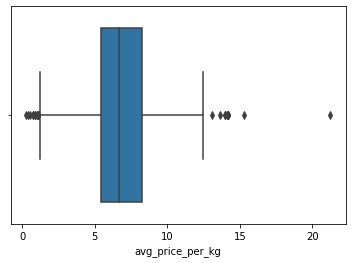

In [31]:
sns.boxplot(x='avg_price_per_kg', data=df_train);

In [32]:
#skewness and kurtosis
print("Skewness: %f" % df_train['avg_price_per_kg'].skew())
print("Kurtosis: %f" % df_train['avg_price_per_kg'].kurt())

Skewness: 0.082452
Kurtosis: 1.042921


Great!, we can see from the above analysis that `avg_price_per_kg` is `Fairly Symmetrical`. A `Kurtosis of less than 3 represent lack of outliers`. However, we might want to do something about `avg_price_per_kg` with a value greater than 20. They're definately `outliers`.

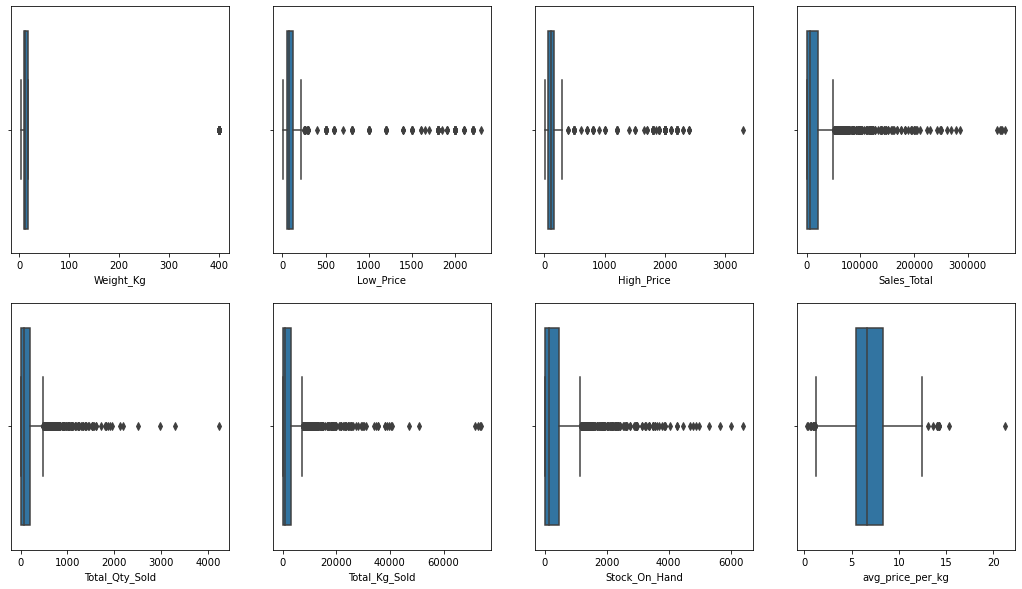

In [33]:
fig, axes = plt.subplots(2, 4, figsize = (18, 10))
sns.boxplot(ax=axes[0,0], data = df_train, x = 'Weight_Kg')
sns.boxplot(ax=axes[0,1], data = df_train, x = 'Low_Price')
sns.boxplot(ax=axes[0,2], data = df_train, x = 'High_Price')
sns.boxplot(ax=axes[0,3], data = df_train, x = 'Sales_Total')
sns.boxplot(ax=axes[1,0], data = df_train, x = 'Total_Qty_Sold')
sns.boxplot(ax=axes[1,1], data = df_train, x = 'Total_Kg_Sold')
sns.boxplot(ax=axes[1,2], data = df_train, x = 'Stock_On_Hand')
sns.boxplot(ax=axes[1,3], data = df_train, x = 'avg_price_per_kg')
plt.show()

### Multivariate Analysis

Alright, so what's the relationship of `avg_price_per_kg` with other variables. Let's find out

#### `avg_price_per_kg` relationship with numerical variables

<AxesSubplot:xlabel='Total_Kg_Sold', ylabel='avg_price_per_kg'>

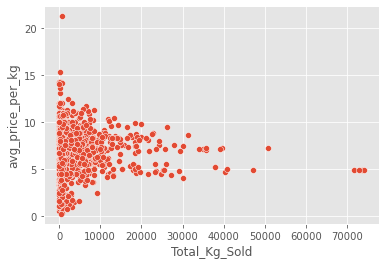

In [34]:
#scatter plot grlivarea/saleprice
plt.style.use('ggplot')
sns.scatterplot(data = df_train, x="Total_Kg_Sold", y="avg_price_per_kg")

<AxesSubplot:xlabel='Sales_Total', ylabel='avg_price_per_kg'>

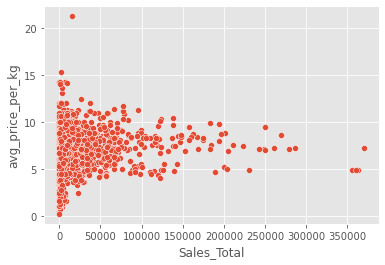

In [35]:
#scatter plot grlivarea/saleprice
sns.scatterplot(data = df_train, x="Sales_Total", y="avg_price_per_kg")

In [36]:
#Stock_On_Hand

In [37]:
df_train.corr()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,avg_price_per_kg
Weight_Kg,1.000000,0.863182,0.905852,0.180518,-0.133317,0.294117,-0.144105,-0.337886
Low_Price,0.863182,1.000000,0.938140,0.183230,-0.122823,0.269744,-0.127677,-0.141740
High_Price,0.905852,0.938140,1.000000,0.265672,-0.096456,0.372282,-0.094174,-0.164496
Sales_Total,0.180518,0.183230,0.265672,1.000000,0.771865,0.962338,0.284693,0.108473
Total_Qty_Sold,-0.133317,-0.122823,-0.096456,0.771865,1.000000,0.651440,0.390168,0.087536
Total_Kg_Sold,0.294117,0.269744,0.372282,0.962338,0.651440,1.000000,0.229062,-0.001007
Stock_On_Hand,-0.144105,-0.127677,-0.094174,0.284693,0.390168,0.229062,1.000000,0.105028
avg_price_per_kg,-0.337886,-0.141740,-0.164496,0.108473,0.087536,-0.001007,0.105028,1.000000


<AxesSubplot:>

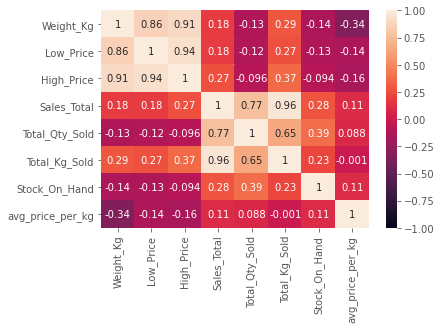

In [38]:
sns.heatmap(df_train.corr(), vmin = -1, vmax = 1, annot = True)

## Feature Engineering and Selection

### Dummy Variables

In [39]:
df_train_ = pd.get_dummies(df_train, drop_first=True)
df_train_.columns = [col.replace(" ","_") for col in df_train_.columns]
df_train_.columns = [col.replace("-","_") for col in df_train_.columns]
df_train_.columns = [col.replace("(","_") for col in df_train_.columns]
df_train_.columns = [col.replace(")","_") for col in df_train_.columns]
df_train_.columns = [col.replace(".","_") for col in df_train_.columns]

### Variable Selection

In [40]:
# import SelectKBest
#from sklearn.feature_selection import SelectKBest

#Let us now try to fit a model but we have to import neccessary tools to do that
#from sklearn.tree import DecisionTreeRegressor

# create a SelectKBest object
#skb = SelectKBest(score_func=mutual_info_regression, k = 10)
# fit the object to the training data
#X_data_new = skb.fit_transform(X_standardise, y)

# print the selected features
#for feature_list_index in skb.get_support(indices = True):
#    print(feature_names[feature_list_index])666

# print the final prediction score
#print(efs.best_score_)

## Variable Selection by Variance Thresholds
Variance Thresholds remove features whose values don't change much from observation to observation. The objective here is to remove all features that have a variance lower than the selected threshold.

For example, suppose that in our loans dataset 97% of observations were for 40-year-old women, then the Age and Gender features can be removed without a great loss in information.

It is important to note that variance is dependent on scale, so the features will have to be normalized before implementing variance thresholding.

df_train_ = df_train_.drop(columns = ['Low_Price', 'Total_Kg_Sold', 'High_Price'])
df_train_.head()

In [41]:
df_train_.corr()['avg_price_per_kg'].abs().sort_values(ascending=False)

avg_price_per_kg                 1.000000
Container_M4183                  0.403229
Province_NATAL                   0.379801
Container_IA400                  0.355565
Size_Grade_2S                    0.352996
Weight_Kg                        0.337886
Container_JE090                  0.322235
Province_W_CAPE_BERGRIVER_ETC    0.262051
Size_Grade_1X                    0.251451
Container_EC120                  0.188162
Province_EASTERN_CAPE            0.178531
Size_Grade_1M                    0.175779
High_Price                       0.164496
Size_Grade_2M                    0.153372
Low_Price                        0.141740
Container_JG110                  0.140148
Container_EF120                  0.114297
Sales_Total                      0.108473
Stock_On_Hand                    0.105028
Size_Grade_2L                    0.089733
Total_Qty_Sold                   0.087536
Size_Grade_2U                    0.069457
Container_DT063                  0.059579
Size_Grade_2X                    0

In [42]:
df_train_.shape

(1952, 33)

In [43]:
plt.figure(figsize = (43,43))
#sns.heatmap(df_train_.corr(), vmin = -1, vmax = 1, annot = True)

<Figure size 3096x3096 with 0 Axes>

<Figure size 3096x3096 with 0 Axes>

#df_train_ = df_train_.drop(columns = ['Container_IA400', 'High_Price', 'Low_Price', 'Total_Kg_Sold'])
df_train_ = df_train_[['avg_price_per_kg',
'Container_M4183',
'Province_NATAL',
'Container_IA400',
'Size_Grade_2S',
'Container_JE090',
'Province_W_CAPE_BERGRIVER_ETC',
'Size_Grade_1X',
'Container_EC120',
'Province_EASTERN_CAPE',
'Size_Grade_1M',
'High_Price',
'Size_Grade_2M',
'Container_JG110',
'Container_EF120',
'Stock_On_Hand']]

In [44]:
column_names = [col for col in df_train_.columns if col!= 'avg_price_per_kg'] + ['avg_price_per_kg']
df_train_ = df_train_.reindex(columns=column_names)

### Checking for Multicollinearity

Multicollinearity refers to the presence of strong correlation among two or more of the predictor variables in the dataset. The presence of any correlation among predictors is detrimental to model quality for two reasons:

## Fitting the model using `statsmodels.OLS`

As was previously motivated within the train, `sklearn` is limited in terms of metrics and tools available to evaluate the appropriateness of the regression models we fit. Thus, as a means to expland our analysis, we import the `statsmodels` library which has a rich set of statistical tools to help us. 

In [45]:
import statsmodels.formula.api as sm

In [46]:
formula_str = df_train_.columns[-1]+' ~ '+'+'.join(df_train_.columns[:-1]); formula_str

'avg_price_per_kg ~ Weight_Kg+Low_Price+High_Price+Sales_Total+Total_Qty_Sold+Total_Kg_Sold+Stock_On_Hand+Province_EASTERN_CAPE+Province_NATAL+Province_ORANGE_FREE_STATE+Province_TRANSVAAL+Province_W_CAPE_BERGRIVER_ETC+Province_WEST_COAST+Container_DT063+Container_EC120+Container_EF120+Container_EG140+Container_IA400+Container_JE090+Container_JG110+Container_M4183+Container_M6125+Container_M9125+Size_Grade_1M+Size_Grade_1S+Size_Grade_1U+Size_Grade_1X+Size_Grade_2L+Size_Grade_2M+Size_Grade_2S+Size_Grade_2U+Size_Grade_2X'

### Construct and fit the model
We now go ahead and fit our model. We use the ols or Ordinary Least Squares regression model from the statsmodels library to do this:

In [47]:
model=sm.ols(formula=formula_str, data=df_train_)

In [48]:
fitted = model.fit()

### Print model summary

In [49]:
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:       avg_price_per_kg   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     97.15
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        12:42:08   Log-Likelihood:                -3430.4
No. Observations:                1952   AIC:                             6925.
Df Residuals:                    1920   BIC:                             7103.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

In [50]:
# Calculate correlations between predictor variables and the response variable
corrs = df_train_.corr()['avg_price_per_kg'].sort_values(ascending=False)

In [51]:
from scipy.stats import pearsonr

# Build a dictionary of correlation coefficients and p-values
dict_cp = {}

column_titles = [col for col in corrs.index if col!= 'avg_price_per_kg']
for col in column_titles:
    p_val = round(pearsonr(df_train_[col], df_train_['avg_price_per_kg'])[1],6)
    dict_cp[col] = {'Correlation_Coefficient':corrs[col],
                    'P_Value':p_val}
    
df_cp = pd.DataFrame(dict_cp).T
df_cp_sorted = df_cp.sort_values('P_Value')
df_cp_sorted[df_cp_sorted['P_Value']<0.05]

,Correlation_Coefficient,P_Value
Container_M4183,0.403229,0.000000
Size_Grade_2S,-0.352996,0.000000
Weight_Kg,-0.337886,0.000000
Container_JE090,-0.322235,0.000000
Province_EASTERN_CAPE,-0.178531,0.000000
High_Price,-0.164496,0.000000
Size_Grade_2M,-0.153372,0.000000
Low_Price,-0.141740,0.000000
Container_JG110,-0.140148,0.000000
Container_IA400,-0.355565,0.000000


In [52]:
# The dependent variable remains the same:
y_data = df_train_['avg_price_per_kg']

# Model building - Independent Variable (IV) DataFrame
X_names = list(df_cp[df_cp['P_Value'] < 0.05].index)
X_data = df_train_[X_names]

In [53]:
# As before, we create the correlation matrix
# and find rows and columnd where correlation coefficients > 0.9 or <-0.9
corr = X_data.corr()
r, c = np.where(np.abs(corr) > 0.9)

# We are only interested in the off diagonal entries:
off_diagonal = np.where(r != c)

# Show the correlation matrix rows and columns where we have highly correlated off diagonal entries:
corr.iloc[r[off_diagonal], c[off_diagonal]]

,High_Price,Low_Price,Weight_Kg,Container_IA400,High_Price,Container_IA400,High_Price,Weight_Kg
Low_Price,0.938140,1.000000,0.863182,0.860219,0.938140,0.860219,0.938140,0.863182
High_Price,1.000000,0.938140,0.905852,0.902518,1.000000,0.902518,1.000000,0.905852
High_Price,1.000000,0.938140,0.905852,0.902518,1.000000,0.902518,1.000000,0.905852
High_Price,1.000000,0.938140,0.905852,0.902518,1.000000,0.902518,1.000000,0.905852
Weight_Kg,0.905852,0.863182,1.000000,0.999231,0.905852,0.999231,0.905852,1.000000
Weight_Kg,0.905852,0.863182,1.000000,0.999231,0.905852,0.999231,0.905852,1.000000
Container_IA400,0.902518,0.860219,0.999231,1.000000,0.902518,1.000000,0.902518,0.999231
Container_IA400,0.902518,0.860219,0.999231,1.000000,0.902518,1.000000,0.902518,0.999231


Container_M4183
Size_Grade_2S
Weight_Kg
Container_JE090
Province_EASTERN_CAPE
Size_Grade_2M
Container_JG110
Province_NATAL
Province_W_CAPE_BERGRIVER_ETC
Size_Grade_1X
Container_EC120
Size_Grade_1M
Container_EF120
Sales_Total
Stock_On_Hand
Size_Grade_2L
Total_Qty_Sold
Size_Grade_2U
Container_DT063
Size_Grade_2X

## Data Scaling
The units of our data are not fit to be used for comparing different variables, this makes it hard for us to study the relationship between different variables. As result, we will scale our data to so that our module is impacted by the relationship between different variables, `NOT` by the units of measurement of the variables. We will use **Z-score standardisation** to scale our data. Z-score standardisation robust to outlier values. 

Let's go ahead an apply standard scaling to our model. We'll import the StandardScalar() object from sklearn.preprocessing

In [54]:
# Split data into predictors and response
X = df_train_.drop('avg_price_per_kg', axis=1)
#X = df_train_.drop(['avg_price_per_kg', 'Weight_Kg', 'High_Price', 'Low_Price', 'Container_IA400'], axis=1)
y = df_train_['avg_price_per_kg']

In [55]:
# Import scaler method from sklearn
from sklearn.preprocessing import StandardScaler

In [56]:
# Create scaler object
scaler = StandardScaler()

In [57]:
# Create scaled version of the predictors (there is no need to scale the response)
X_scaled = scaler.fit_transform(X)

In [58]:
# Convert the scaled predictor values into a dataframe
X_standardise = pd.DataFrame(X_scaled,columns=X.columns)
X_standardise.head()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,...,Container_M9125,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X
0,-0.222433,-0.065087,-0.105317,0.811807,0.510117,0.511073,0.571070,-0.343488,-0.245547,-0.068059,...,-0.039233,-0.44198,-0.612085,-0.032026,-0.30986,-0.255934,-0.367265,-0.432837,-0.093731,-0.116187
1,-0.295704,-0.332855,-0.382175,-0.103950,0.471248,0.091837,-0.563874,-0.343488,-0.245547,-0.068059,...,-0.039233,-0.44198,-0.612085,-0.032026,-0.30986,-0.255934,2.722828,-0.432837,-0.093731,-0.116187
2,-0.315779,-0.319467,-0.370639,-0.488870,-0.506948,-0.459029,1.515476,-0.343488,-0.245547,-0.068059,...,-0.039233,-0.44198,-0.612085,-0.032026,-0.30986,-0.255934,-0.367265,2.310338,-0.093731,-0.116187
3,-0.222433,-0.252525,-0.220674,0.306871,0.691504,0.679187,0.047781,-0.343488,-0.245547,-0.068059,...,-0.039233,-0.44198,1.633760,-0.032026,-0.30986,-0.255934,-0.367265,-0.432837,-0.093731,-0.116187
4,3.608756,4.353082,3.655338,-0.468098,-0.562012,-0.419986,-0.561112,2.911310,-0.245547,-0.068059,...,-0.039233,-0.44198,1.633760,-0.032026,-0.30986,-0.255934,-0.367265,-0.432837,-0.093731,-0.116187


## Regression Models
We will first split our data into a training and a testing set. Let's go ahead and import neccessary libraries

In [59]:
# Import train/test splitting function from sklearn
from sklearn.model_selection import train_test_split

In [60]:
# Import metrics module
from sklearn import metrics

In [61]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, y, test_size=0.2, shuffle=False)

## Linear Regression
### Preprocessing

In [62]:
# Import the ridge regression module from sklearn
from sklearn.linear_model import LinearRegression

In [63]:
# Create linear model
lm = LinearRegression()

In [64]:
# Train the model
lm.fit(X_train, y_train)

LinearRegression()

In [65]:
# Extract the model intercept value
b0 = float(lm.intercept_)

In [66]:
# Extract the model coefficient value
coeff = pd.DataFrame(lm.coef_, X.columns, columns=['Coefficient'])

In [67]:
print("Intercept:", float(b0))

Intercept: 6.802441647399473


In [68]:
# Check out the coefficients
coeff

,Coefficient
Weight_Kg,4.812878e+12
Low_Price,2.124187e-01
High_Price,6.673675e-01
Sales_Total,2.726347e+00
Total_Qty_Sold,-6.712441e-01
Total_Kg_Sold,-2.180760e+00
Stock_On_Hand,-7.338064e-02
Province_EASTERN_CAPE,-4.513408e-01
Province_NATAL,-4.351203e-01
Province_ORANGE_FREE_STATE,-1.250759e-01


### Assess the predictive accuracy of the model

In [69]:
# Check training accuracy
train_lm = lm.predict(X_train)

print('Ridge Training RMSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_lm)))
print('Ridge Training R-Squared: ', metrics.r2_score(y_train, train_lm))

Ridge Training RMSE:  1.3918616392274834
Ridge Training R-Squared:  0.6105789617008179


In [70]:
# Check testing accuracy
test_lm = lm.predict(X_test)

print('Ridge Testing RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_lm)))
print('Ridge Testing R-Squared: ', metrics.r2_score(y_test, test_lm))

Ridge Testing RMSE:  1.4556631198530379
Ridge Testing R-Squared:  0.6032493895000703


## Decision Tree
### Preprocessing
We will first split our data into a training and a testing set. Let's go ahead and import neccessary libraries

In [137]:
#Let us now try to fit a model but we have to import neccessary tools to do that
from sklearn.tree import DecisionTreeRegressor

In [138]:
regr_tree = DecisionTreeRegressor(max_depth=10, random_state=42)

In [139]:
regr_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

### Assess the predictive accuracy of the model

In [140]:
# get predictions for test data
# Check training accuracy
y_train_pred = regr_tree.predict(X_train)

print('Ridge Training RMSE: ', np.sqrt(metrics.mean_squared_error(y_train2, y_train_pred)))
print('Ridge Training R-Squared: ', metrics.r2_score(y_train, y_train_pred))

Ridge Training RMSE:  0.24901111196232956
Ridge Training R-Squared:  0.987535790655654


In [141]:
# Check testing accuracy
# Check testing accuracy
y_test_pred = regr_tree.predict(X_test)

print('Decision Tree Testing RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))
print('Decision Tree Testing R-Squared: ', metrics.r2_score(y_test, y_test_pred))

Decision Tree Testing RMSE:  0.6000024898778094
Decision Tree Testing R-Squared:  0.9325934730905606


## Ridge Regression
### Preprocessing
We will first split our data into a training and a testing set. Let's go ahead and import neccessary libraries

In [142]:
# Import the ridge regression module from sklearn
from sklearn.linear_model import Ridge

In [143]:
# Create ridge model
ridge = Ridge()

In [144]:
# Train the model
ridge.fit(X_train, y_train)

Ridge()

In [145]:
# Extract the model intercept value
b0 = float(ridge.intercept_)

In [146]:
# Extract the model coefficient value
coeff = pd.DataFrame(ridge.coef_, X.columns, columns=['Coefficient'])

In [147]:
print("Intercept:", float(b0))

Intercept: 6.802567832768915


In [148]:
# Check out the coefficients
coeff

,Coefficient
Weight_Kg,-0.579887
Low_Price,0.219775
High_Price,0.657435
Sales_Total,2.621535
Total_Qty_Sold,-0.648125
Total_Kg_Sold,-2.092840
Stock_On_Hand,-0.073679
Province_EASTERN_CAPE,-0.451105
Province_NATAL,-0.436849
Province_ORANGE_FREE_STATE,-0.124633


### Assess the predictive accuracy of the model

In [149]:
# Check training accuracy
train_ridge = ridge.predict(X_train)

print('Ridge Training RMSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_ridge)))
print('Ridge Training R-Squared: ', metrics.r2_score(y_train, train_ridge))

Ridge Training RMSE:  1.3919586584879011
Ridge Training R-Squared:  0.610524670876457


In [150]:
# Check testing accuracy
test_ridge = ridge.predict(X_test)

print('Ridge Testing RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_ridge)))
print('Ridge Testing R-Squared: ', metrics.r2_score(y_test, test_ridge))

Ridge Testing RMSE:  1.4547643751333355
Ridge Testing R-Squared:  0.6037391558940142


## LASSO Regression
### Preprocessing
We'll be using the same dataset and train/test split as in previous regression trains.

In [151]:
# Import LASSO module
from sklearn.linear_model import Lasso

In [152]:
# Split the data into train and test, being sure to use the standardised predictors
X_train, X_test, y_train, y_test = train_test_split(X_standardise, y, test_size=0.2, shuffle=False)

In [153]:
# Create LASSO model object, setting alpha to 0.01
lasso = Lasso(alpha=0.1)

In [154]:
# Train the LASSO model
lasso.fit(X_train, y_train)

Lasso(alpha=0.1)

In [155]:
# Extract intercept from model
intercept = float(lasso.intercept_)

In [156]:
# Extract coefficient from model
coeff = pd.DataFrame(lasso.coef_, X.columns, columns=['Coefficient'])

In [157]:
# Extract intercept
print("Intercept:", float(intercept))

Intercept: 6.800852523069083


In [158]:
coeff[coeff.Coefficient == 0]

,Coefficient
Weight_Kg,-0.0
High_Price,0.0
Total_Qty_Sold,-0.0
Total_Kg_Sold,0.0
Stock_On_Hand,-0.0
Province_ORANGE_FREE_STATE,-0.0
Province_TRANSVAAL,-0.0
Province_WEST_COAST,-0.0
Container_DT063,-0.0
Container_EG140,0.0


### Assess the predictive accuracy of the model

In [159]:
# Check training accuracy
train_lasso = lasso.predict(X_train)

print('Ridge Training RMSE: ', np.sqrt(metrics.mean_squared_error(y_train, train_lasso)))
print('Ridge Training R-Squared: ', metrics.r2_score(y_train, train_lasso))

Ridge Training RMSE:  1.589749968001641
Ridge Training R-Squared:  0.4919751817037331


In [160]:
# Check testing accuracy
test_lasso = lasso.predict(X_test)

print('Ridge Testing RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, test_lasso)))
print('Ridge Testing R-Squared: ', metrics.r2_score(y_test, test_lasso))

Ridge Testing RMSE:  1.6079158433231062
Ridge Testing R-Squared:  0.5159140537271931


## Predicting on the test set
Preprocessing
The first thing we need to do is to get our data in the correct format. We will use the same techniques we used when preparing the training data to ensure we do not get any errors.

### Preprocessing

In [161]:
x_test_ = pd.get_dummies(df_test, drop_first=True)
x_test_.columns = [col.replace(" ","_") for col in x_test_.columns]
x_test_.columns = [col.replace("-","_") for col in x_test_.columns]
x_test_.columns = [col.replace("(","_") for col in x_test_.columns]
x_test_.columns = [col.replace(")","_") for col in x_test_.columns]
x_test_.columns = [col.replace(".","_") for col in x_test_.columns]
x_test_.head()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,...,Container_M9125,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X
0,12.0,128.0,136.0,5008.0,38,456.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,18.3,220.0,220.0,1760.0,8,146.4,2,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,12.0,120.0,120.0,720.0,6,72.0,45,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,18.3,160.0,160.0,160.0,1,18.3,8,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,18.3,140.0,160.0,14140.0,100,1830.0,19,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [162]:
# Create scaled version of the predictors (there is no need to scale the response)
x_tests = scaler.fit_transform(x_test_)

In [163]:
x_test_standardised = pd.DataFrame(x_tests, columns=x_test_.columns)
x_test_standardised.head()

,Weight_Kg,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Province_EASTERN_CAPE,Province_NATAL,Province_ORANGE_FREE_STATE,...,Container_M9125,Size_Grade_1M,Size_Grade_1S,Size_Grade_1U,Size_Grade_1X,Size_Grade_2L,Size_Grade_2M,Size_Grade_2S,Size_Grade_2U,Size_Grade_2X
0,-0.253022,-0.102006,-0.153257,-0.406172,-0.457601,-0.448904,-0.613932,-0.366205,-0.173422,-0.07664,...,-0.038236,2.249877,-0.608276,-0.038236,-0.361058,-0.261998,-0.373854,-0.388922,-0.115385,-0.085749
1,-0.181032,0.157216,0.062779,-0.501907,-0.557890,-0.510145,-0.611136,-0.366205,-0.173422,-0.07664,...,-0.038236,-0.444469,-0.608276,-0.038236,2.769636,-0.261998,-0.373854,-0.388922,-0.115385,-0.085749
2,-0.253022,-0.124547,-0.194406,-0.532562,-0.564576,-0.524862,-0.551035,-0.366205,-0.173422,-0.07664,...,-0.038236,-0.444469,1.643990,-0.038236,-0.361058,-0.261998,-0.373854,-0.388922,-0.115385,-0.085749
3,-0.181032,-0.011842,-0.091532,-0.549068,-0.581291,-0.535484,-0.602750,-0.366205,-0.173422,-0.07664,...,-0.038236,2.249877,-0.608276,-0.038236,-0.361058,-0.261998,-0.373854,-0.388922,-0.115385,-0.085749
4,-0.181032,-0.068195,-0.091532,-0.137004,-0.250335,-0.177117,-0.587375,-0.366205,-0.173422,-0.07664,...,-0.038236,-0.444469,-0.608276,-0.038236,-0.361058,-0.261998,-0.373854,-0.388922,-0.115385,-0.085749


### Making predictions

In [164]:
preds = regr_tree.predict(x_test_standardised)

In [165]:
preds

array([ 7.67555556, 11.25      ,  8.14      ,  9.47636364,  8.75073171,
        5.33      ,  4.55      ,  8.75073171,  8.75073171,  9.92      ,
        4.62833333,  5.75      ,  9.01058824,  5.        ,  5.02      ,
        5.25214286,  8.14      ,  5.02      , 10.89      ,  5.87428571,
        4.88875   ,  5.25      ,  4.62833333,  6.25      ,  5.78      ,
        6.91      ,  6.23      ,  8.14636364,  7.318     ,  8.14636364,
        9.01058824,  5.6       , 10.41571429,  8.2       ,  5.3       ,
       10.6025    , 11.33      , 11.16333333,  5.6       ,  7.318     ,
        8.86      ,  9.44      ,  5.46      ,  5.25214286,  5.78      ,
        4.88875   ,  5.11      ,  5.78      ,  5.25214286,  5.3       ,
        2.        ,  4.62833333,  7.39      , 14.1       ,  8.14      ,
        6.76      ,  8.42555556,  8.75073171,  8.14636364,  5.2       ,
        8.67714286, 11.16333333,  5.25214286,  9.46277778,  5.174     ,
        5.4       ,  5.555     ,  4.454     ,  5.52      ,  7.67

### Submission

In [166]:
# create submission dataframe
# Create Dataframe of Order_No and Time from Pickup to Arrival
submission = pd.DataFrame(
    {'Index': test_index,
     'avg_price_per_kg': preds
    })

In [167]:
submission.head()

,Index,avg_price_per_kg
0,1,7.675556
1,2,11.250000
2,3,8.140000
3,4,9.476364
4,5,8.750732


In [168]:
# save DataFrame to csv file for submission
submission.to_csv("Regression_AM2_DSFT.csv", index=False)